# VECM
- Using a VECM to predict FANG stocks
- See the [VECM documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Auxmodels.html#vecm)

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.Pipeline import Transformer, Reverter, MVPipeline
from scalecast.util import (
    find_optimal_lag_order, 
    find_optimal_coint_rank,
    Forecaster_with_missing_vals,
)
from scalecast.auxmodels import vecm
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator
import matplotlib.pyplot as plt

In [2]:
yf.pdr_override()

## Download data using a public API

In [3]:
FANG = [
    'META',
    'AMZN',
    'NFLX',
    'GOOG',
]

fs = []
for sym in FANG:
    df = pdr.get_data_yahoo(sym)
    # since the api doesn't send the data exactly in Business-day frequency
    # we can correct it using this function
    f = Forecaster_with_missing_vals(
        y=df['Close'],
        current_dates = df.index,
        future_dates = 65,
        end = '2022-09-30',
        desired_frequency = 'B',
        fill_strategy = 'linear_interp',
        add_noise = True,
        noise_lookback = 5,
    )
    fs.append(f)
    
mvf = MVForecaster(*fs,names=FANG,test_length=65)
mvf.set_validation_metric('rmse')
mvf.add_sklearn_estimator(vecm,'vecm')

mvf

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


MVForecaster(
    DateStartActuals=2012-05-18T00:00:00.000000000
    DateEndActuals=2023-08-03T00:00:00.000000000
    Freq=B
    N_actuals=2925
    N_series=4
    SeriesNames=['META', 'AMZN', 'NFLX', 'GOOG']
    ForecastLength=65
    Xvars=[]
    TestLength=65
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    OptimizeOn=mean
    GridsFile=MVGrids
)

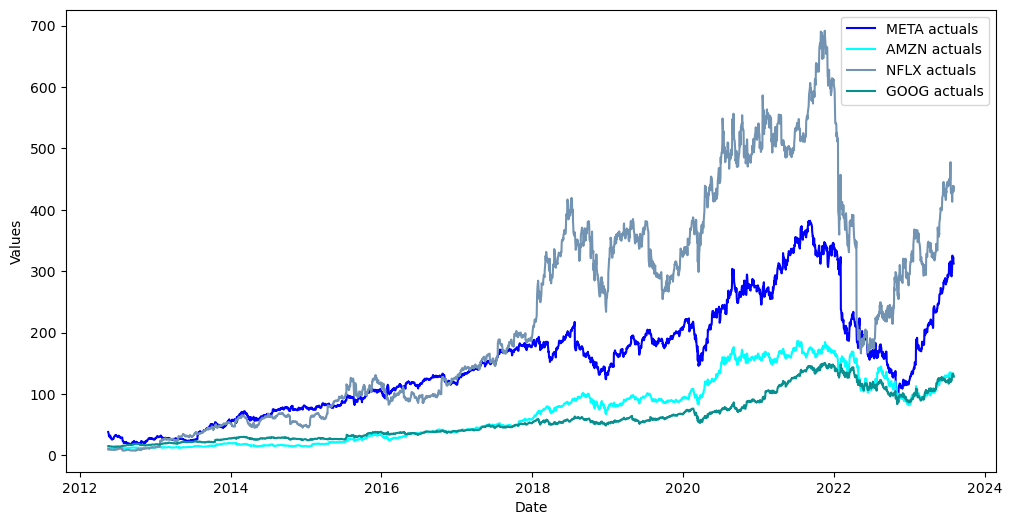

In [4]:
mvf.plot()
plt.show()

## Augmented Dickey Fuller Tests to Confirm Unit-1 Roots

In [5]:
for stock, f in zip(FANG,fs):
    adf_result = f.adf_test(full_res=True)
    print('the stock {} is {}stationary at level'.format(
        stock,
        'not ' if adf_result[1] > 0.05 else ''
    )
    )

the stock META is not stationary at level
the stock AMZN is not stationary at level
the stock NFLX is not stationary at level
the stock GOOG is not stationary at level


In [6]:
for stock, f in zip(FANG,fs):
    adf_result = f.adf_test(diffy=True,full_res=True)
    print('the stock {} is {}stationary at its first difference'.format(
        stock,
        'not ' if adf_result[1] > 0.05 else ''
    )
    )

the stock META is stationary at its first difference
the stock AMZN is stationary at its first difference
the stock NFLX is stationary at its first difference
the stock GOOG is stationary at its first difference


## Measure IC to Find Optimal Lag Order
- this is used to run the cointegration test

In [7]:
lag_test = find_optimal_lag_order(mvf,train_only=True)
pd.DataFrame(
    {
        'aic':lag_test.aic,
        'bic':lag_test.bic,
        'hqic':lag_test.hqic,
        'fpe':lag_test.fpe,
    },
    index = ['optimal lag order'],
).T

,optimal lag order
aic,27
bic,1
hqic,3
fpe,27


## Johansen cointegration test

In [8]:
coint_res = find_optimal_coint_rank(
    mvf,
    det_order=1,
    k_ar_diff=10,
    train_only=True,
)
print(coint_res)
coint_res.rank

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   4          56.60          55.25
  1   4          33.50          35.01
-------------------------------------


1

We found a cointegration rank of 1.

## Run VECM
- Now, we can specify a grid that will try more lags, deterministic terms, seasonal fluctuations, and cointegration ranks of 0 and 1

In [9]:
vecm_grid = dict(
    lags = [0], # required to set this to 0 for the vecm model in scalecast
    freq = ['B'], # only necessary to suppress a warning
    k_ar_diff = range(1,66), # lag orders to try
    coint_rank = [0,1],
    deterministic = ["n","co","lo","li","cili","colo"],
    seasons = [0,5,30,65,260],
)

mvf.set_estimator('vecm')
mvf.ingest_grid(vecm_grid)
mvf.limit_grid_size(100,random_seed=20)
mvf.cross_validate(k=3,verbose=True)
mvf.auto_forecast()

results = mvf.export('model_summaries')
results[[
    'ModelNickname',
    'Series',
    'TestSetRMSE',
    'TestSetMAE',
]]

Num hyperparams to try for the vecm model: 100.
Fold 0: Train size: 2145 (2012-05-18 00:00:00 - 2020-08-06 00:00:00). Test Size: 715 (2020-08-07 00:00:00 - 2023-05-04 00:00:00). 
Fold 1: Train size: 1430 (2012-05-18 00:00:00 - 2017-11-09 00:00:00). Test Size: 715 (2017-11-10 00:00:00 - 2020-08-06 00:00:00). 
Fold 2: Train size: 715 (2012-05-18 00:00:00 - 2015-02-12 00:00:00). Test Size: 715 (2015-02-13 00:00:00 - 2017-11-09 00:00:00). 
Chosen paramaters: {'lags': 0, 'freq': 'B', 'k_ar_diff': 28, 'coint_rank': 1, 'deterministic': 'li', 'seasons': 5}.


,ModelNickname,Series,TestSetRMSE,TestSetMAE
0,vecm,META,50.913814,44.133838
1,vecm,AMZN,23.752750,22.348669
2,vecm,NFLX,113.705564,105.310047
3,vecm,GOOG,18.846431,18.041912


## View VECM Results

In [10]:
results['TestSetRMSE'].mean()

51.80463965264752

In [11]:
mvf.export_validation_grid('vecm').sample(15)

,lags,freq,k_ar_diff,coint_rank,deterministic,seasons,Fold0Metric,Fold1Metric,Fold2Metric,AverageMetric,MetricEvaluated,Optimized On
71,0,B,58,0,colo,0,162.599874,44.268484,26.594518,77.820958,rmse,mean
40,0,B,7,0,li,260,NaN,NaN,NaN,NaN,rmse,mean
3,0,B,54,1,lo,30,110.553065,51.443275,19.154490,60.383610,rmse,mean
30,0,B,29,0,co,30,112.035140,44.427934,18.598329,58.353801,rmse,mean
76,0,B,1,1,cili,65,93.945660,51.090754,21.836356,55.624257,rmse,mean
87,0,B,50,0,lo,260,163.152289,46.616014,13.327631,74.365311,rmse,mean
10,0,B,44,0,cili,65,NaN,NaN,NaN,NaN,rmse,mean
9,0,B,47,0,n,0,86.212252,55.639330,36.182421,59.344668,rmse,mean
94,0,B,38,1,colo,5,139.580751,41.852200,24.055439,68.496130,rmse,mean
43,0,B,55,1,colo,260,112.237679,43.782141,63.595936,73.205252,rmse,mean


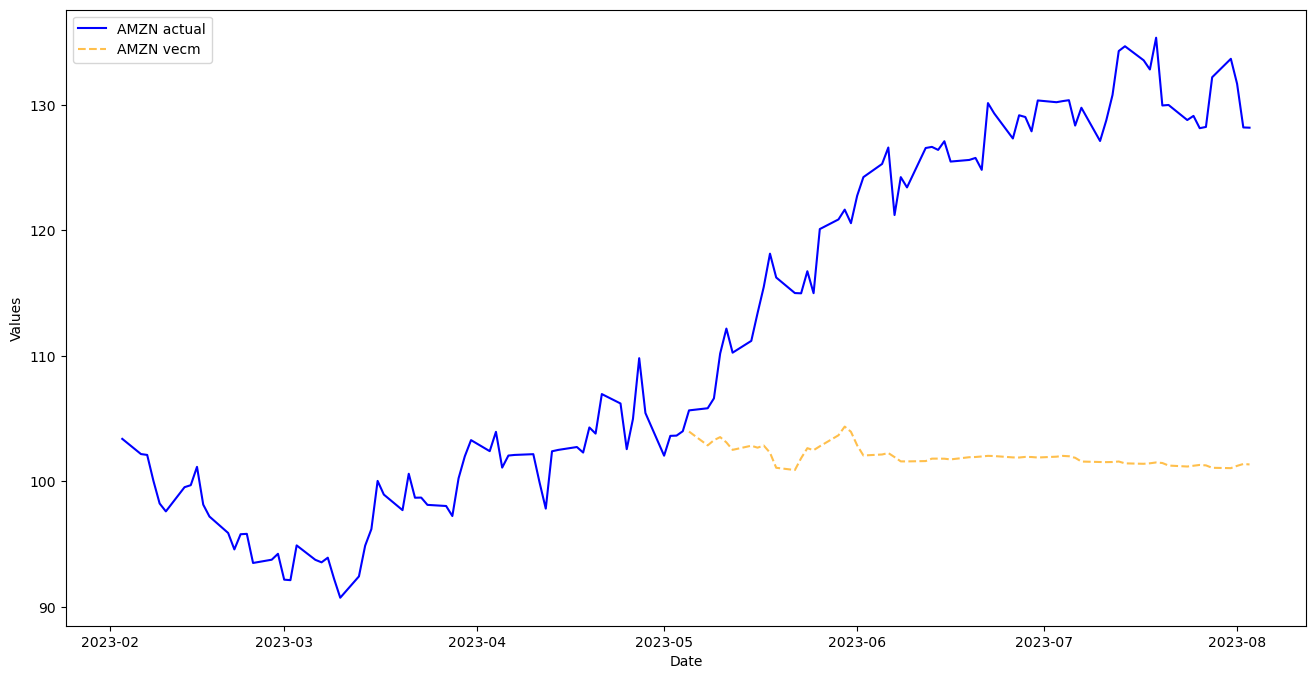

In [12]:
mvf.plot_test_set(
    series='AMZN',
    models='vecm',
    include_train=130,
    figsize=(16,8)
)
plt.show()

## Re-weight Evaluation Metrics and Rerun VECM

In [13]:
weights = results['TestSetRMSE'] / results['TestSetRMSE'].sum()
weights

0    0.245701
1    0.114627
2    0.548723
3    0.090950
Name: TestSetRMSE, dtype: float64

In [14]:
mvf.set_optimize_on(
    lambda x: (
        x[0]*weights[0] + 
        x[1]*weights[1] + 
        x[2]*weights[2] + 
        x[3]*weights[3]
    )
)
mvf.ingest_grid(vecm_grid)
mvf.limit_grid_size(100,random_seed=20)
mvf.cross_validate(k=3,verbose=True)
mvf.auto_forecast(call_me='vecm_weighted')

results = mvf.export('model_summaries')
results[[
    'ModelNickname',
    'Series',
    'TestSetRMSE',
    'TestSetMAE',
]]

Num hyperparams to try for the vecm model: 100.
Fold 0: Train size: 2145 (2012-05-18 00:00:00 - 2020-08-06 00:00:00). Test Size: 715 (2020-08-07 00:00:00 - 2023-05-04 00:00:00). 
Fold 1: Train size: 1430 (2012-05-18 00:00:00 - 2017-11-09 00:00:00). Test Size: 715 (2017-11-10 00:00:00 - 2020-08-06 00:00:00). 
Fold 2: Train size: 715 (2012-05-18 00:00:00 - 2015-02-12 00:00:00). Test Size: 715 (2015-02-13 00:00:00 - 2017-11-09 00:00:00). 
Chosen paramaters: {'lags': 0, 'freq': 'B', 'k_ar_diff': 62, 'coint_rank': 1, 'deterministic': 'li', 'seasons': 0}.


,ModelNickname,Series,TestSetRMSE,TestSetMAE
0,vecm,META,50.913814,44.133838
1,vecm_weighted,META,33.772797,28.520031
2,vecm,AMZN,23.752750,22.348669
3,vecm_weighted,AMZN,15.835426,14.617043
4,vecm,NFLX,113.705564,105.310047
5,vecm_weighted,NFLX,59.887563,53.210215
6,vecm,GOOG,18.846431,18.041912
7,vecm_weighted,GOOG,16.757831,16.121594


In [15]:
results.loc[results['ModelNickname'] == 'vecm_weighted','TestSetRMSE'].mean()

31.56340410699967

An improvement by weighting the optimizer!

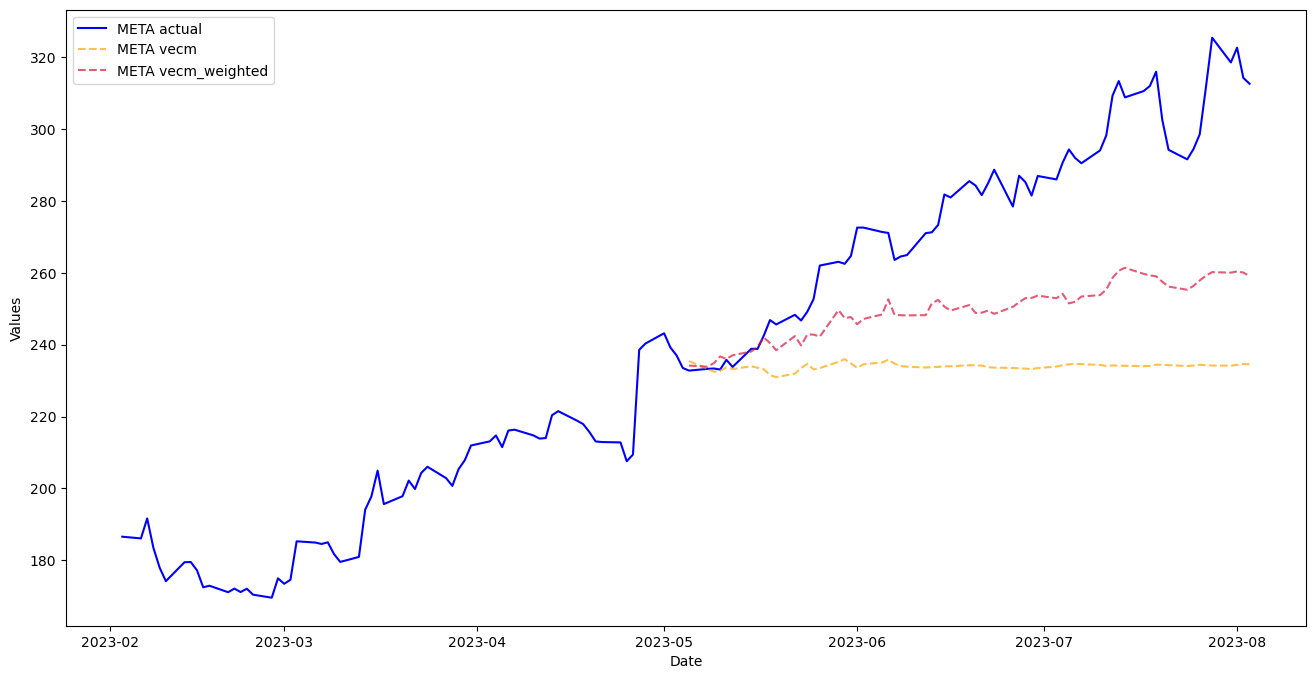

In [16]:
mvf.plot_test_set(
    series='META',
    models='all',
    include_train=130,
    figsize=(16,8)
)
plt.show()

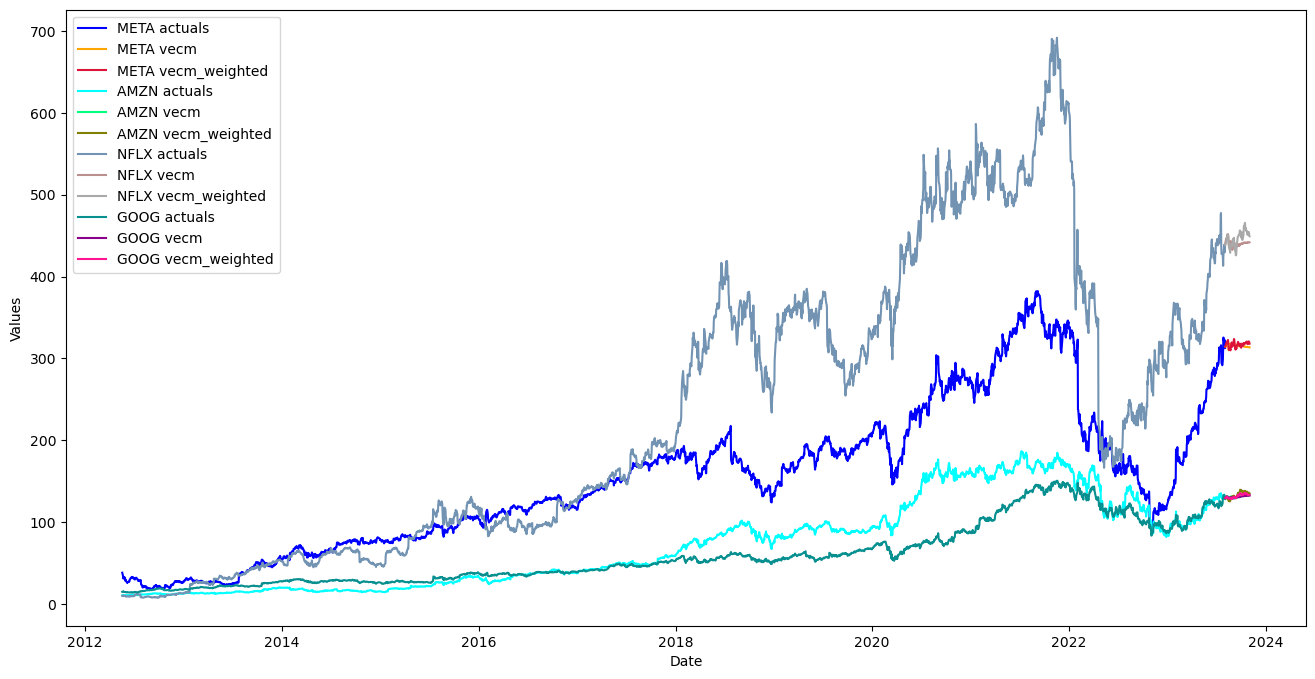

In [17]:
mvf.plot(
    series='all',
    models='all',
    figsize=(16,8)
)
plt.show()

## Try Other MV Models

In [31]:
GridGenerator.get_mv_grids()
# open MVGrids.py and manually change all lags arguments to range(1,66)

In [32]:
transformers = []
reverters = []
for stock, f in zip(FANG,fs):
    transformer = Transformer(
        transformers = [('DiffTransform',)]
    )
    reverter = Reverter(
        reverters = [('DiffRevert',)],
        base_transformer = transformer,
    )
    transformers.append(transformer)
    reverters.append(reverter)

In [33]:
def Xvar_select(f):
    f.set_validation_length(65)
    f.auto_Xvar_select(
        estimator='gbt',
        max_depth=2,
        max_ar=0, # in mv modeling, lags are a hyperparameter, not a regressor in the MVForecaster object
    )

def mvforecaster(mvf):
    models = (
        'mlr',
        'elasticnet',
        'gbt',
        'xgboost',
        'lightgbm',
        'knn',
    )
    mvf.set_test_length(65)
    mvf.tune_test_forecast(
        models,
        limit_grid_size=10,
        cross_validate=True,
        k=3,
    )

In [34]:
pipeline = MVPipeline(
    steps = [
        ('Transform',transformers),
        ('Xvar Select',[Xvar_select]*4),
        ('Forecast',mvforecaster),
        ('Revert',reverters),
    ],
    names = FANG,
)

In [35]:
fs = pipeline.fit_predict(*fs)

Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations


In [36]:
results = export_model_summaries(dict(zip(FANG,fs)))

## View Results

In [37]:
model_rmses = results.groupby('ModelNickname')['TestSetRMSE'].mean().sort_values().reset_index()
model_rmses

,ModelNickname,TestSetRMSE
0,xgboost,27.918698
1,knn,41.832711
2,mlr,42.519262
3,gbt,43.895070
4,elasticnet,44.320649
5,lightgbm,44.554279


The above table is the mean mape performance from each model over all series.

In [38]:
series_rmses = results.groupby('Series')['TestSetRMSE'].min().reset_index()
series_rmses['Model'] = [
    results.loc[
        results['TestSetRMSE'] == i,
        'ModelNickname'
    ].values[0] for i in series_rmses['TestSetRMSE']
]
series_rmses

,Series,TestSetRMSE,Model
0,AMZN,17.433315,xgboost
1,GOOG,12.892690,xgboost
2,META,10.509525,xgboost
3,NFLX,70.839262,xgboost


In [39]:
series_rmses['TestSetRMSE'].mean()

27.918697955026953

The above table shows the best model for each series and its derived RMSE. The average RMSE of all these models applied to the individual series is 27.9, but being so dependent on the test set to choose the model probably leads to overfitting.

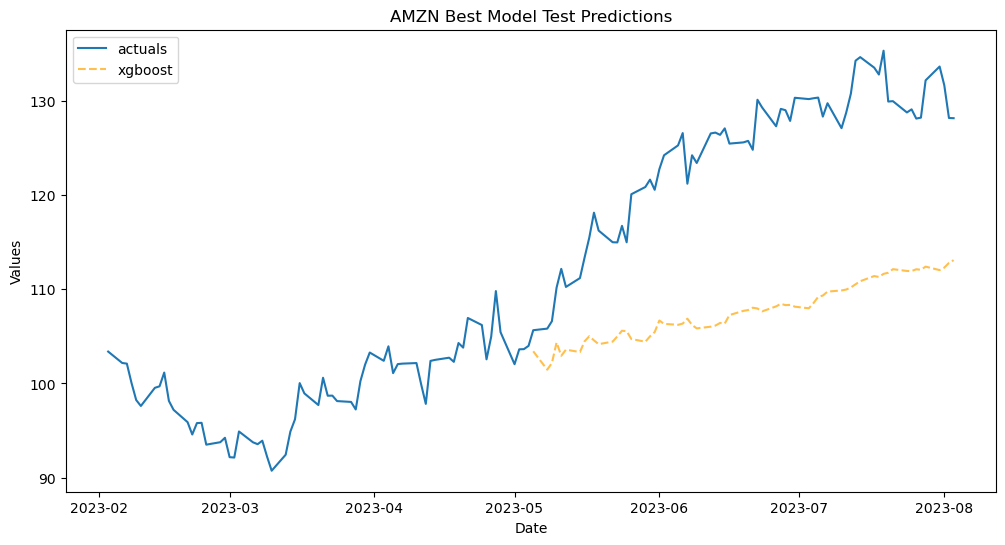

In [41]:
fs[1].plot_test_set(
    models='xgboost',
    include_train=130,
)
plt.title('AMZN Best Model Test Predictions')
plt.show()

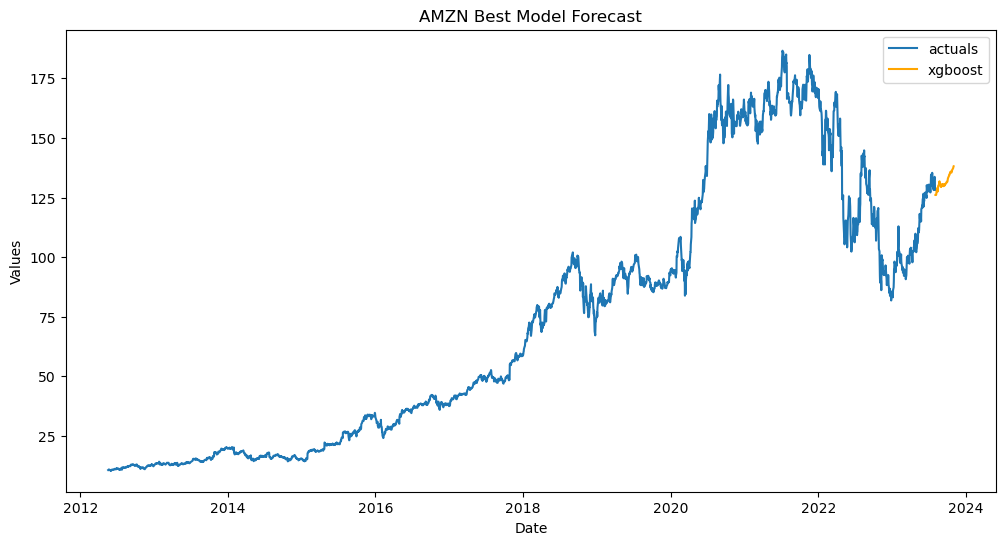

In [42]:
fs[1].plot(
    models='xgboost',
)
plt.title('AMZN Best Model Forecast')
plt.show()